# Table of contents
1. [Introduction](#Introduction)
2. [Data Preparation](#Data-Preparation)
    1. [Data Exploration](#Data-Exploration)
        1. [Class Distribution](#Class-Distribution)
        2. [Size Distribution](#Size-Distribution)
    2. [Data Preprocessing](#Data-Preprocessing)
    3. [Data Augmentation](#Data-Augmentation)
3. [Prediction Model](#Prediction-Model)
4. [Conclusion](#Conclusion)

# Introduction <a name="Introduction"></a>

The goal of this challenge is to provide solid approaches to plankton image classification. The notebook is structured in such a way as to explore different tasks, including but not limited to data preparation and model selection.

# Data Preparation <a name="Data-Preparation"></a>

The data set we will be using is composed of ~240K gray scale plankton images that were acquired in the bay of Villefranche and manually engineered features that were computed on each imaged object.

## Data Exploration <a name="Data-Exploration"></a>

First, let's import the data set, have a look at the different available labels and the distribution of images among these classes.

In [ ]:
import utils
from PIL import Image
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
img_files = utils.extract_zip_to_memory("/content/drive/My Drive/plankton_challenge/imgs.zip")

AttributeError: ignored

In [ ]:
np_ids, np_data = zip(*sorted(img_files.items()))
del img_files

In [ ]:
np_ids, np_data = list(map(lambda s: int(''.join(filter(str.isdigit, s))), np_ids)), list(map(lambda img: np.array(Image.open(img)), np_data))

In [ ]:
del np_ids

In [ ]:
meta_df = pd.read_csv("/content/drive/My Drive/plankton_challenge/meta.csv")
sorted_level2 = meta_df.groupby('level2').size().sort_values(ascending=False)
sorted_level2.head()

level2
detritus               138439
feces                   26936
Neoceratium             14014
nauplii (Crustacea)      9293
badfocus (artefact)      7848
dtype: int64

### Class Distribution <a name="Class-Distribution"></a>

The next plot shows how many images are available for each class in a descending order.

Note: A linear scale is used between 0 and 100 occurences in order to clearly visualize classes with few occurences. And a log scale is used for occurences above 100 since values can reach $10^5$ for the detritus class.

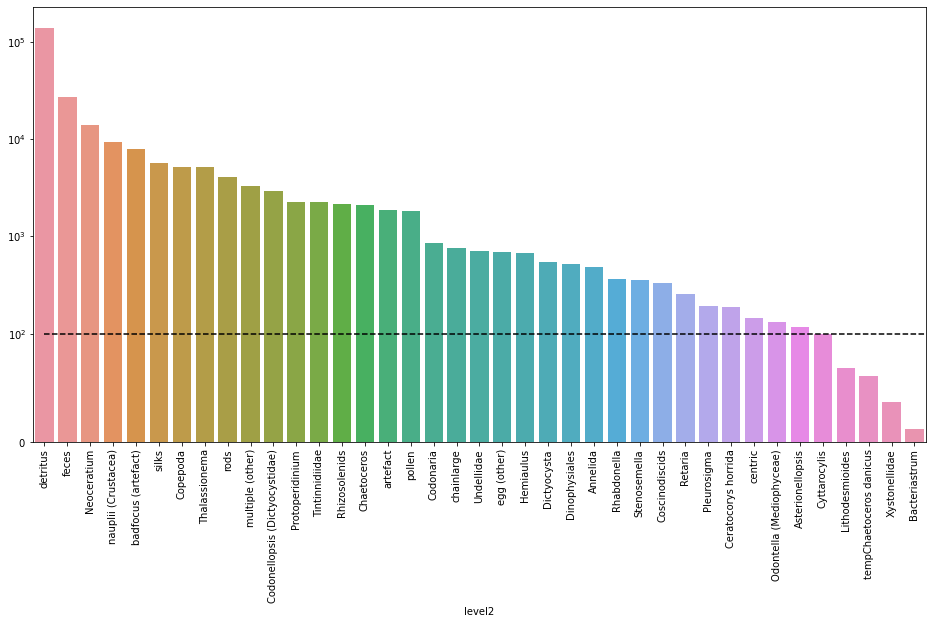

In [ ]:
fog, ax = plt.subplots(figsize=(16, 8))
y_thresh = 1e2
ax.set_yscale('symlog', linthreshy=y_thresh)
ax.hlines(y=y_thresh, xmin=0, xmax=39, linestyles='dashed')
ax.tick_params(axis='x', labelrotation=90)
sns.barplot(x=sorted_level2.index, y=sorted_level2.values, ax=ax)

We can clearly see that we have an imbalanced data set. Working with such a distrubution will have a negative impact classifying images from under represented classes such as Bacteriastrum (12 samples), Xystonellidae (37 samples), etc. because the model won't be able to lean much about those classes.

One solution for this problem is to use data augmentation. This approach will be discussed later.

### Size Distribution <a name="Size-Distribution"></a>

Now, we will focus on shapes of images. This is an important feature since we are working with an image data set because it will have a direct impact on the training process, e.g, performance and training time.

Let's start by displaying 30 images randomly picked from the data set.

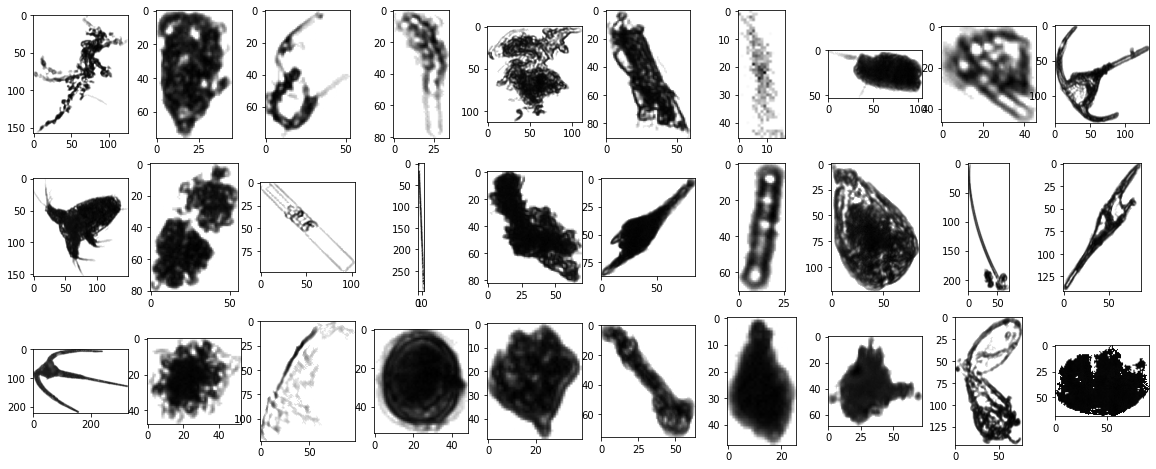

In [ ]:
utils.plot(data=np_data, seed=5)

We can see that the images have different shapes. We are going to have a closer look on the distribusion of images' dimesions.

In [ ]:
widths, heights = zip(*map(lambda x:x.shape, np_data))

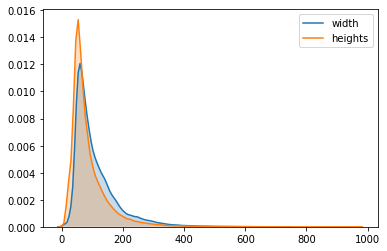

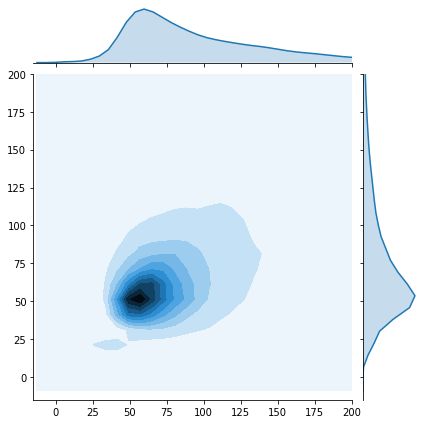

In [ ]:
sns.kdeplot(list(widths), label='width', shade=True)
sns.kdeplot(list(heights), label='heights', shade=True)

g2 = sns.jointplot(x=widths, 
                    y=heights, 
                    kind="kde", 
                    xlim=(-15,200),
                    ylim=(-15,200))

In [ ]:
del widths
del heights

The KDE plot is used to have a global view on the distribution of the shapes. We can see that the images have very different shapes that vary from few pixels up to about 1000 pixels. 

The joint plot was a good way to have a closer look on the distribusion of images' dimesions that are between 0 and 200 pixels. That helps us to choose the resizing value to be used.

We decided to rescale all images to 64x64x1 pixels for three main reasons:
* We will be using a convolutional neural network so all input samples should have the same size.
* As we can see in the joint plot, the shape distribution is concentrated around this value so 
* This value is not too small so we keep important information, and not too big so training process is much faster.

Resizing the images is based on a a bicubic interpolation over 4x4 pixel neighborhood method already implemented in OpenCV.

## Data Preprocessing <a name="Data-Preprocessing"></a>

In [ ]:
np_reshaped_data = list(map(lambda img : utils.reshape(img, 64), np_data))

del np_data

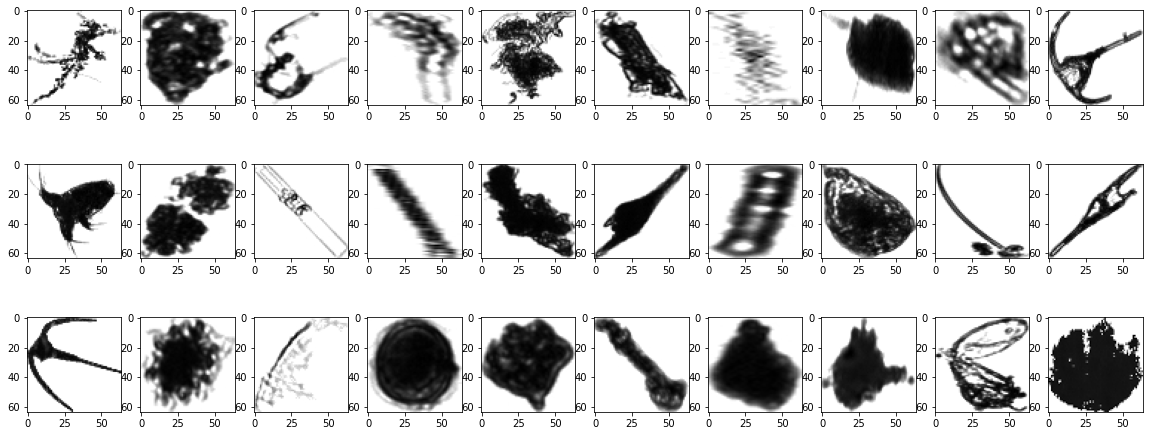

In [ ]:
utils.plot(data=np_reshaped_data, seed=5)

In [ ]:
np_reshaped_data = np.expand_dims(np.asarray(np_reshaped_data) / 255.0, axis=3)

Finally, we convert data to a NumPy array and scale all pixel intensities to the range [0, 1]. This will help speeding up gradient convergence during the training step.

A neural network cannot operate on label data directly. It requires all input variables and output variables to be numeric. That's why we perform integer encoding for the data labels which transforms categorical data into numerical fields.

In [ ]:
labelencoder = LabelEncoder()
meta_df["level2_label"] = labelencoder.fit_transform(meta_df["level2"].astype(str))
np_y = meta_df.sort_values(by=['objid'])[['objid', 'level2_label']].astype(int).values[:,1]

In [ ]:
print("Input shape:", np_reshaped_data.shape)
print("Target shape:", np_y.shape)

Input shape: (243610, 64, 64, 1)
Target shape: (243610,)


# MODEL SELECTION

One of the solutions to solve the problem of imblanced data distribution through the different classes is to perform data augmentation which consists of creating new data samples from the original ones by applying random perturbations to increase the size of the data set. Various transformation can be used such as rotation, translation, rescaling, flipping, etc.

We are going to use on-the-fly data augmentation using ImageDataGenerator class provided by Keras. That means this augmentation will be done at the training time.

In [ ]:
!unzip  -q "/content/drive/My Drive/plankton_challenge/imgs.zip" -d data


Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.optimizers.novograd import NovoGrad
from tensorflow.nn import leaky_relu
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D , Dense,MaxPooling2D,Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd

IMG_SIZE=(64,64)
meta_df = pd.read_csv("/content/drive/My Drive/plankton_challenge/meta.csv")

cat_targets = pd.factorize(meta_df['level2'])[0]+1 ## We want targets  to start from 0
hot_targets = pd.get_dummies(cat_targets)
hot_targets=hot_targets.set_index(meta_df['objid'].astype(int))


NUM_IMG=cat_targets.size
BATCH_SIZE=512
EPOCHS=5
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
weights=compute_class_weight('balanced',np.unique(cat_targets),cat_targets)
class_weights= dict(zip(np.unique(cat_targets),weights))

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

class ImageWithLabels(DirectoryIterator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.objids = np.array([int(path[12:20]) for path in self.filepaths])
        self.class_mode = None # so that we only get the images back
    def __targets__(self,one_hot):
      self.targets=one_hot.loc[self.objids].reset_index(drop=True).values

    def _get_batches_of_transformed_samples(self, index_array):
        return (super()._get_batches_of_transformed_samples(index_array),
                self.targets[index_array])
    

In [ ]:
imagegen =  ImageDataGenerator(
	rescale=1./255,
  data_format="channels_last",
	validation_split=0.2)

train_gen = ImageWithLabels(directory='./data', image_data_generator=imagegen, target_size=IMG_SIZE,batch_size=BATCH_SIZE,shuffle=True,subset='training')
train_gen.__targets__(hot_targets)


validation_gen = ImageWithLabels(directory='./data', image_data_generator=imagegen, target_size=IMG_SIZE,batch_size=BATCH_SIZE,subset='validation')
validation_gen.__targets__(hot_targets)






Found 194888 images belonging to 1 classes.
Found 48722 images belonging to 1 classes.


In [ ]:
LeNet = Sequential([
    Conv2D(6, (2, 2), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(),
    Conv2D(16, (2, 2),activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (2, 2),activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(250, activation='relu'),
    Dense(100, activation='relu'),
    Dense(40,activation='softmax')
])


opt=tf.keras.optimizers.Adam()

LeNet.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy',tfa.metrics.F1Score(num_classes=40,average='macro')])

#LeNet.summary()

In [ ]:
LeNet.fit(train_gen, epochs=EPOCHS,validation_data=validation_gen,class_weight=class_weights,workers=2)


Epoch 1/5
381/381 [==============================] - 133s 348ms/step - loss: 2.7916 - accuracy: 0.0705 - f1_score: 0.0600 - val_loss: 2.9884 - val_accuracy: 0.0850 - val_f1_score: 0.0840
Epoch 2/5
381/381 [==============================] - 135s 355ms/step - loss: 2.2223 - accuracy: 0.1212 - f1_score: 0.1123 - val_loss: 3.0421 - val_accuracy: 0.1080 - val_f1_score: 0.1073
Epoch 3/5
381/381 [==============================] - 136s 357ms/step - loss: 1.8949 - accuracy: 0.1690 - f1_score: 0.1487 - val_loss: 2.6452 - val_accuracy: 0.2522 - val_f1_score: 0.1779
Epoch 4/5
381/381 [==============================] - 136s 356ms/step - loss: 1.7234 - accuracy: 0.2067 - f1_score: 0.1715 - val_loss: 2.4030 - val_accuracy: 0.3030 - val_f1_score: 0.1848
Epoch 5/5
381/381 [==============================] - 135s 353ms/step - loss: 1.5442 - accuracy: 0.2312 - f1_score: 0.1863 - val_loss: 2.1625 - val_accuracy: 0.3584 - val_f1_score: 0.2096


In [ ]:
input1 = keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
features1 = LeNet(input1)
input2 = keras.layers.Input(shape=(32,))
features2 = keras.layers.Dense(40, activation='relu')(input2)
# equivalent to added = keras.layers.add([x1, x2])
added = keras.layers.Add()([x1, x2])

out = keras.layers.Dense(40,activation='softmax')(added)
model = keras.models.Model(inputs=[input1, input2], outputs=out)

In [ ]:
from tensorflow.keras.applications import VGG19
# Create the base model of VGG19
base_model= VGG19 ( include_top=False, input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3), classes = 40)


# Create the base model from the pre-trained model MobileNet 
# base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
#                                                include_top=False, 
#                                                weights='imagenet')

base_model.trainable = False

model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(4096,activation='relu'),
  Dense(40, activation='sigmoid')
])


model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy',tfa.metrics.F1Score(num_classes=40,average='macro')])